In [1]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 15)
%matplotlib inline
import pandas as pd
import numpy as np


from darts.utils.statistics import plot_acf, check_seasonality
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.metrics import mape, r2_score, mse, rmse

from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.missing_values import fill_missing_values
from darts.utils.likelihood_models import GaussianLikelihood
from darts import concatenate

### HYDRO DATA

In [2]:
hydro_data_csv = '/cuvalley_23/Zadanie3-data/hydro+2021+2022.xlsx'

In [84]:
hydro_df = pd.read_excel(hydro_data_csv, header=2, names=['Data', 'GŁOGÓW (151160060)', 'RACIBÓRZ-MIEDONIA (150180060)'], converters= {'data': pd.to_datetime})
hydro_df.head()

,Data,GŁOGÓW (151160060),RACIBÓRZ-MIEDONIA (150180060)
0,2011-11-01,199.0,118.0
1,2011-11-02,200.0,118.0
2,2011-11-03,194.0,119.0
3,2011-11-04,195.0,118.0
4,2011-11-05,192.0,116.0


In [85]:
# create timeseries only for GŁOGÓW (151160060) station 
hydro_ts = TimeSeries.from_dataframe(hydro_df[['Data', 'GŁOGÓW (151160060)']], time_col='Data')

In [86]:
# skip first 2 months from hydro data to start timestamp with meteo data
hydro_ts = hydro_ts[61:]

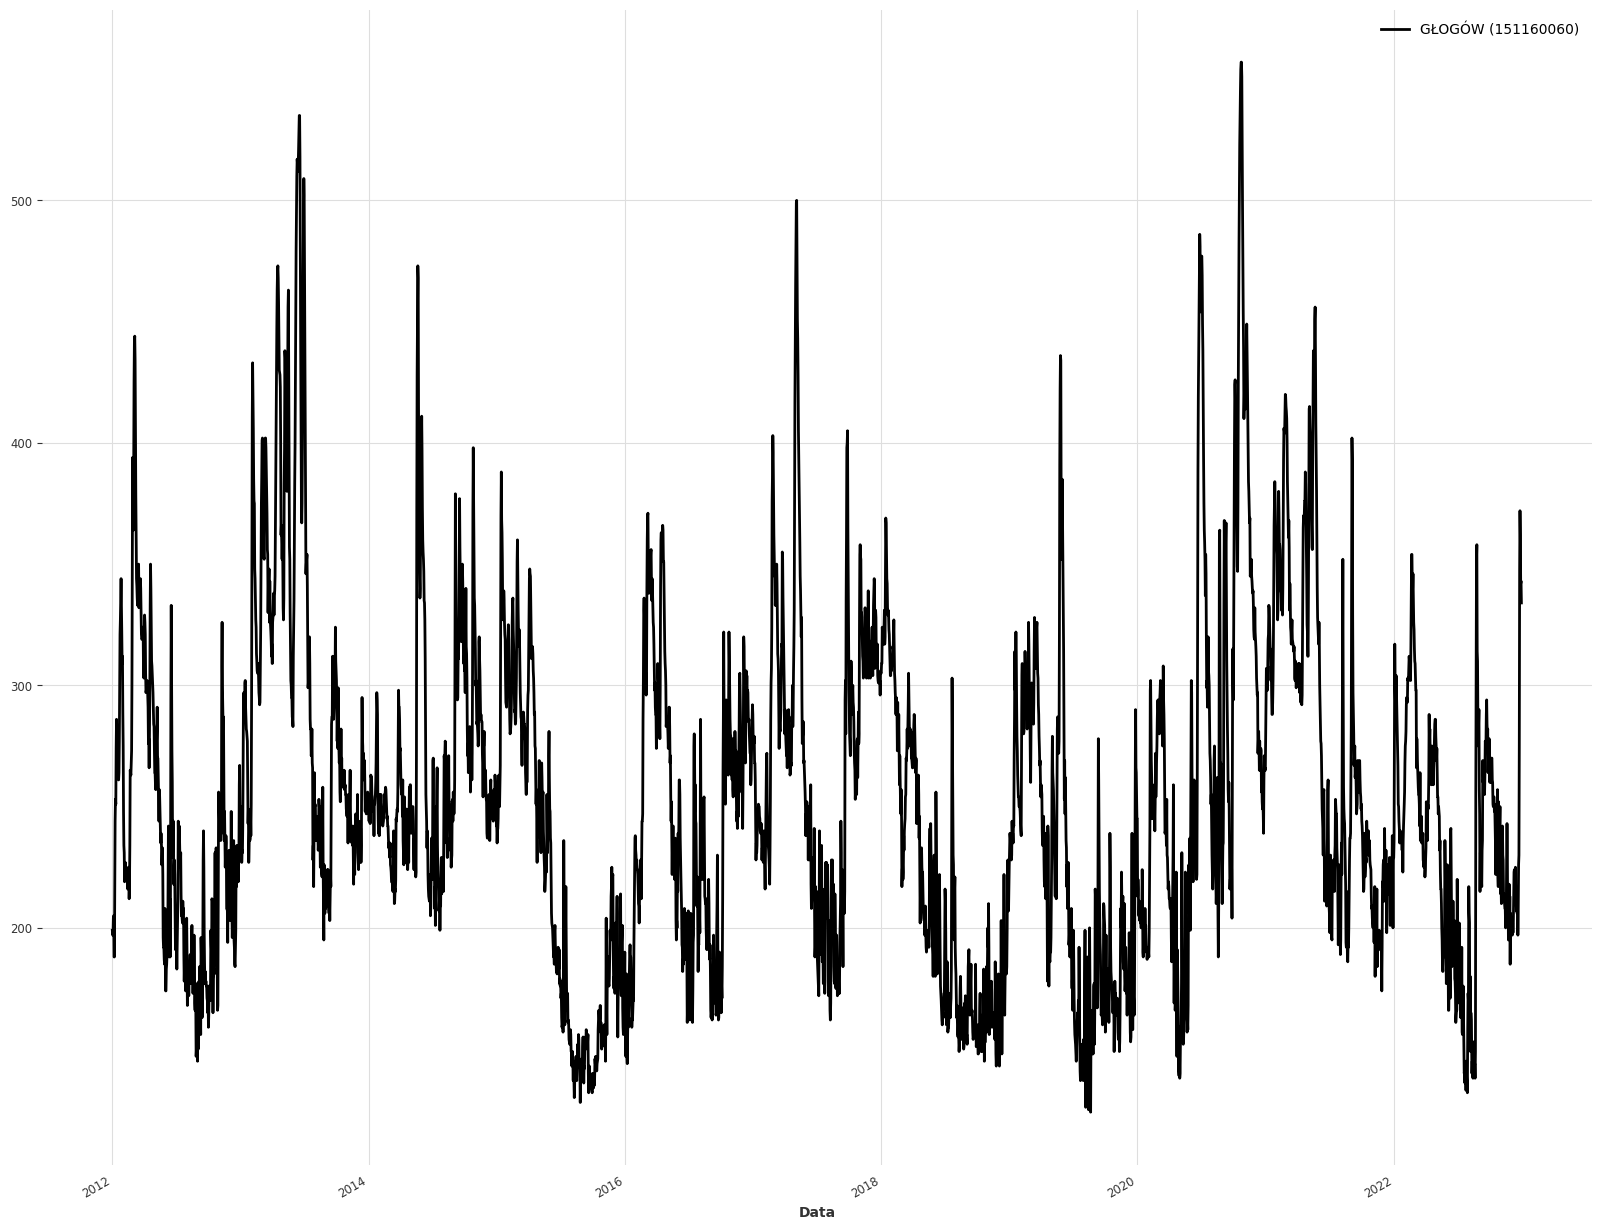

In [87]:
hydro_ts.plot()

In [88]:
hydro_scaler = Scaler()
hydro_ts = hydro_scaler.fit_transform(hydro_ts)

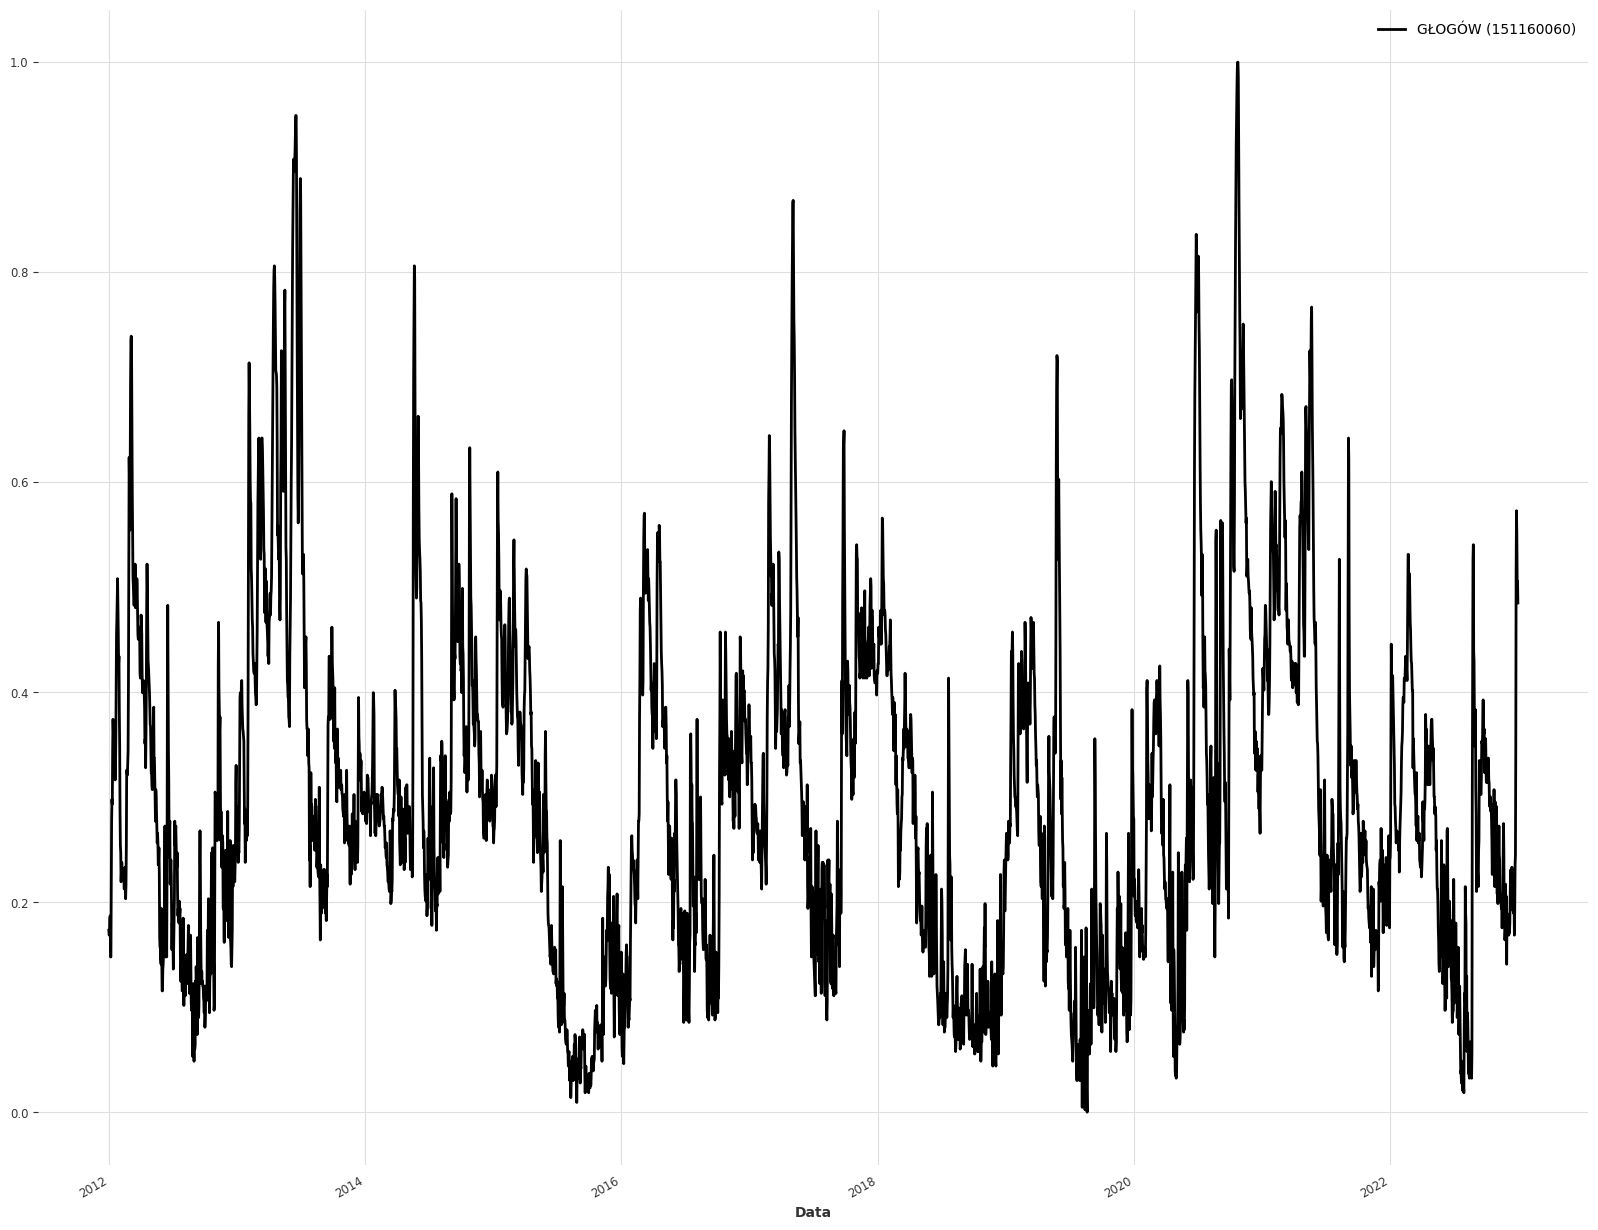

In [89]:
hydro_ts.plot()

In [90]:
# split hydro timeseries into train and val 
hydro_train, hydro_val = hydro_ts.split_after(pd.Timestamp("20221130"))

### METEO DATA

In [18]:
meteo_data_csv = '/cuvalley_23/Zadanie3-data/meteo.csv'

In [19]:
meteo_df = pd.read_csv(meteo_data_csv, encoding= 'unicode_escape', sep=';')
meteo_df = meteo_df.fillna(0)

In [20]:
meteo_df.head()

,Data,Suma opad¢w [mm],Status sumy opad¢w,Suma opad¢w [mm].1,Status sumy opad¢w.1,Suma opad¢w [mm].2,Status sumy opad¢w.2,Suma opad¢w [mm].3,Status sumy opad¢w.3,Suma opad¢w [mm].4,...,Suma opad¢w [mm].81,Status sumy opad¢w.81,Suma opad¢w [mm].82,Status sumy opad¢w.82,Suma opad¢w [mm].83,Status sumy opad¢w.83,Suma opad¢w [mm].84,Status sumy opad¢w.84,Suma opad¢w [mm].85,Status sumy opad¢w.85
0,01-01-2012,0.2,0.0,0.5,0.0,0.5,0.0,0.7,0.0,0.2,...,0.0,0.0,0.3,0.0,7.0,0.0,0.5,0.0,0.0,0.0
1,02-01-2012,0.0,0.0,1.1,0.0,1.0,0.0,0.8,0.0,0.0,...,0.1,0.0,0.2,0.0,1.3,0.0,0.0,0.0,0.0,0.0
2,03-01-2012,2.2,0.0,0.9,0.0,5.6,0.0,0.0,0.0,0.0,...,0.2,0.0,0.1,0.0,9.5,0.0,0.0,0.0,0.0,0.0
3,04-01-2012,2.4,0.0,0.1,0.0,12.5,0.0,0.0,0.0,0.0,...,5.2,0.0,0.0,0.0,12.6,0.0,0.9,0.0,0.0,0.0
4,05-01-2012,8.9,0.0,7.1,0.0,23.0,0.0,10.2,0.0,0.5,...,12.9,0.0,2.5,0.0,46.0,0.0,6.1,0.0,0.0,0.0


In [21]:
meteo_df_only_data = meteo_df.drop(columns=['Data'])

In [22]:
# tylko co druga kolumna
meteo_df_only_data = meteo_df_only_data.loc[:, ::2]

In [23]:
meteo_df_only_data.head()

,Suma opad¢w [mm],Suma opad¢w [mm].1,Suma opad¢w [mm].2,Suma opad¢w [mm].3,Suma opad¢w [mm].4,Suma opad¢w [mm].5,Suma opad¢w [mm].6,Suma opad¢w [mm].7,Suma opad¢w [mm].8,Suma opad¢w [mm].9,...,Suma opad¢w [mm].76,Suma opad¢w [mm].77,Suma opad¢w [mm].78,Suma opad¢w [mm].79,Suma opad¢w [mm].80,Suma opad¢w [mm].81,Suma opad¢w [mm].82,Suma opad¢w [mm].83,Suma opad¢w [mm].84,Suma opad¢w [mm].85
0,0.2,0.5,0.5,0.7,0.2,0.0,0.8,0.8,0.2,0.0,...,0.0,0.6,0.8,0.0,0.5,0.0,0.3,7.0,0.5,0.0
1,0.0,1.1,1.0,0.8,0.0,0.3,0.6,1.3,4.0,0.0,...,0.3,0.1,0.0,0.5,2.2,0.1,0.2,1.3,0.0,0.0
2,2.2,0.9,5.6,0.0,0.0,0.0,0.1,0.0,0.1,0.0,...,0.0,0.0,0.0,0.1,0.0,0.2,0.1,9.5,0.0,0.0
3,2.4,0.1,12.5,0.0,0.0,0.6,0.5,1.5,11.0,0.0,...,1.8,0.2,1.1,1.8,0.2,5.2,0.0,12.6,0.9,0.0
4,8.9,7.1,23.0,10.2,0.5,1.0,3.0,6.5,4.3,0.0,...,5.4,10.5,6.6,8.8,9.3,12.9,2.5,46.0,6.1,0.0


In [24]:
meteo_df = meteo_df['Data']

In [25]:
meteo_df_only_data.insert(0, 'Data', meteo_df)

In [26]:
meteo_df_only_data.head()

,Data,Suma opad¢w [mm],Suma opad¢w [mm].1,Suma opad¢w [mm].2,Suma opad¢w [mm].3,Suma opad¢w [mm].4,Suma opad¢w [mm].5,Suma opad¢w [mm].6,Suma opad¢w [mm].7,Suma opad¢w [mm].8,...,Suma opad¢w [mm].76,Suma opad¢w [mm].77,Suma opad¢w [mm].78,Suma opad¢w [mm].79,Suma opad¢w [mm].80,Suma opad¢w [mm].81,Suma opad¢w [mm].82,Suma opad¢w [mm].83,Suma opad¢w [mm].84,Suma opad¢w [mm].85
0,01-01-2012,0.2,0.5,0.5,0.7,0.2,0.0,0.8,0.8,0.2,...,0.0,0.6,0.8,0.0,0.5,0.0,0.3,7.0,0.5,0.0
1,02-01-2012,0.0,1.1,1.0,0.8,0.0,0.3,0.6,1.3,4.0,...,0.3,0.1,0.0,0.5,2.2,0.1,0.2,1.3,0.0,0.0
2,03-01-2012,2.2,0.9,5.6,0.0,0.0,0.0,0.1,0.0,0.1,...,0.0,0.0,0.0,0.1,0.0,0.2,0.1,9.5,0.0,0.0
3,04-01-2012,2.4,0.1,12.5,0.0,0.0,0.6,0.5,1.5,11.0,...,1.8,0.2,1.1,1.8,0.2,5.2,0.0,12.6,0.9,0.0
4,05-01-2012,8.9,7.1,23.0,10.2,0.5,1.0,3.0,6.5,4.3,...,5.4,10.5,6.6,8.8,9.3,12.9,2.5,46.0,6.1,0.0


In [27]:
meteo_df_only_data.tail()

,Data,Suma opad¢w [mm],Suma opad¢w [mm].1,Suma opad¢w [mm].2,Suma opad¢w [mm].3,Suma opad¢w [mm].4,Suma opad¢w [mm].5,Suma opad¢w [mm].6,Suma opad¢w [mm].7,Suma opad¢w [mm].8,...,Suma opad¢w [mm].76,Suma opad¢w [mm].77,Suma opad¢w [mm].78,Suma opad¢w [mm].79,Suma opad¢w [mm].80,Suma opad¢w [mm].81,Suma opad¢w [mm].82,Suma opad¢w [mm].83,Suma opad¢w [mm].84,Suma opad¢w [mm].85
4072,24-02-2023,4.5,1.9,6.0,9.2,3.1,1.9,3.4,3.2,0.9,...,5.9,0.2,3.5,0.5,8.2,4.8,3.2,6.5,3.4,0.0
4073,25-02-2023,0.1,0.5,0.0,0.2,0.1,0.1,0.1,0.3,0.3,...,0.2,0.6,0.2,0.3,0.6,0.0,0.4,1.1,0.0,0.0
4074,26-02-2023,0.5,0.2,0.0,0.7,0.7,0.2,0.0,0.6,0.6,...,0.3,0.6,0.6,0.0,0.8,1.3,0.2,0.8,1.1,0.0
4075,27-02-2023,0.1,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,...,1.4,0.8,0.5,0.0,1.1,1.1,0.0,0.8,0.1,0.0
4076,28-02-2023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.3,0.0,0.1,0.0,0.2,0.2,0.0,0.0


In [28]:
meteo_df_only_data['Data']

0       01-01-2012
1       02-01-2012
2       03-01-2012
3       04-01-2012
4       05-01-2012
           ...    
4072    24-02-2023
4073    25-02-2023
4074    26-02-2023
4075    27-02-2023
4076    28-02-2023
Name: Data, Length: 4077, dtype: object

In [29]:
meteo_df_only_data = meteo_df_only_data.set_index('Data')

In [30]:
# set Data column as time index
meteo_df_only_data.index = pd.DatetimeIndex(meteo_df_only_data.index, dayfirst=True)

In [31]:
meteo_df_only_data.index

DatetimeIndex(['2012-01-01', '2012-01-02', '2012-01-03', '2012-01-04',
               '2012-01-05', '2012-01-06', '2012-01-07', '2012-01-08',
               '2012-01-09', '2012-01-10',
               ...
               '2023-02-19', '2023-02-20', '2023-02-21', '2023-02-22',
               '2023-02-23', '2023-02-24', '2023-02-25', '2023-02-26',
               '2023-02-27', '2023-02-28'],
              dtype='datetime64[ns]', name='Data', length=4077, freq=None)

In [32]:
meteo_ts = TimeSeries.from_dataframe(meteo_df_only_data)

In [33]:
meteo_scaler = Scaler()
meteo_ts = meteo_scaler.fit_transform(meteo_ts)

In [92]:
# build probabilistic RNN model (almost identical to DeepAR state-of-the-art forecasting model)

deep_ar = RNNModel(
    model="LSTM",
    hidden_dim=75,
    n_rnn_layers=2,
    dropout=0,
    batch_size=32,
    n_epochs=50,
    optimizer_kwargs={"lr": 1e-3},
    random_state=0,
    training_length=40,
    input_chunk_length=30,
    likelihood=GaussianLikelihood()
)

In [93]:
# train on hydro train data and add future covariates as rainfall data
deep_ar.fit(series=hydro_train, future_covariates=meteo_ts, verbose=True)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/biadmin/anaconda3/envs/cuvalley_23/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 94.8 K
4 | V             | Linear           | 152   
---------------------------------------------------
95.0 K    Trainable params
0         Non-trainable params
95.0 K    Total params
0.760     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [124]:
# predict historical hydro data 
hydro_pred_historical_1_day = deep_ar.historical_forecasts(
    series=hydro_ts,
    future_covariates=meteo_ts,
    start=pd.Timestamp("20221130"),
    forecast_horizon=1,
    stride=1,
    retrain=False,
    last_points_only=True,
    verbose=True,
    num_samples=50,
)

hydro_pred_historical_10_day = deep_ar.historical_forecasts(
    series=hydro_ts,
    future_covariates=meteo_ts,
    start=pd.Timestamp("20221130"),
    forecast_horizon=10,
    stride=1,
    retrain=False,
    last_points_only=True,
    verbose=True,
    num_samples=10,
)

  0%|          | 0/32 [00:00<?, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/biadmin/anaconda3/envs/cuvalley_23/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

In [ ]:
# PLOTS AND METRICS

MAPE: 11.2264%
MSE: 0.0017%
RMSE: 0.0413


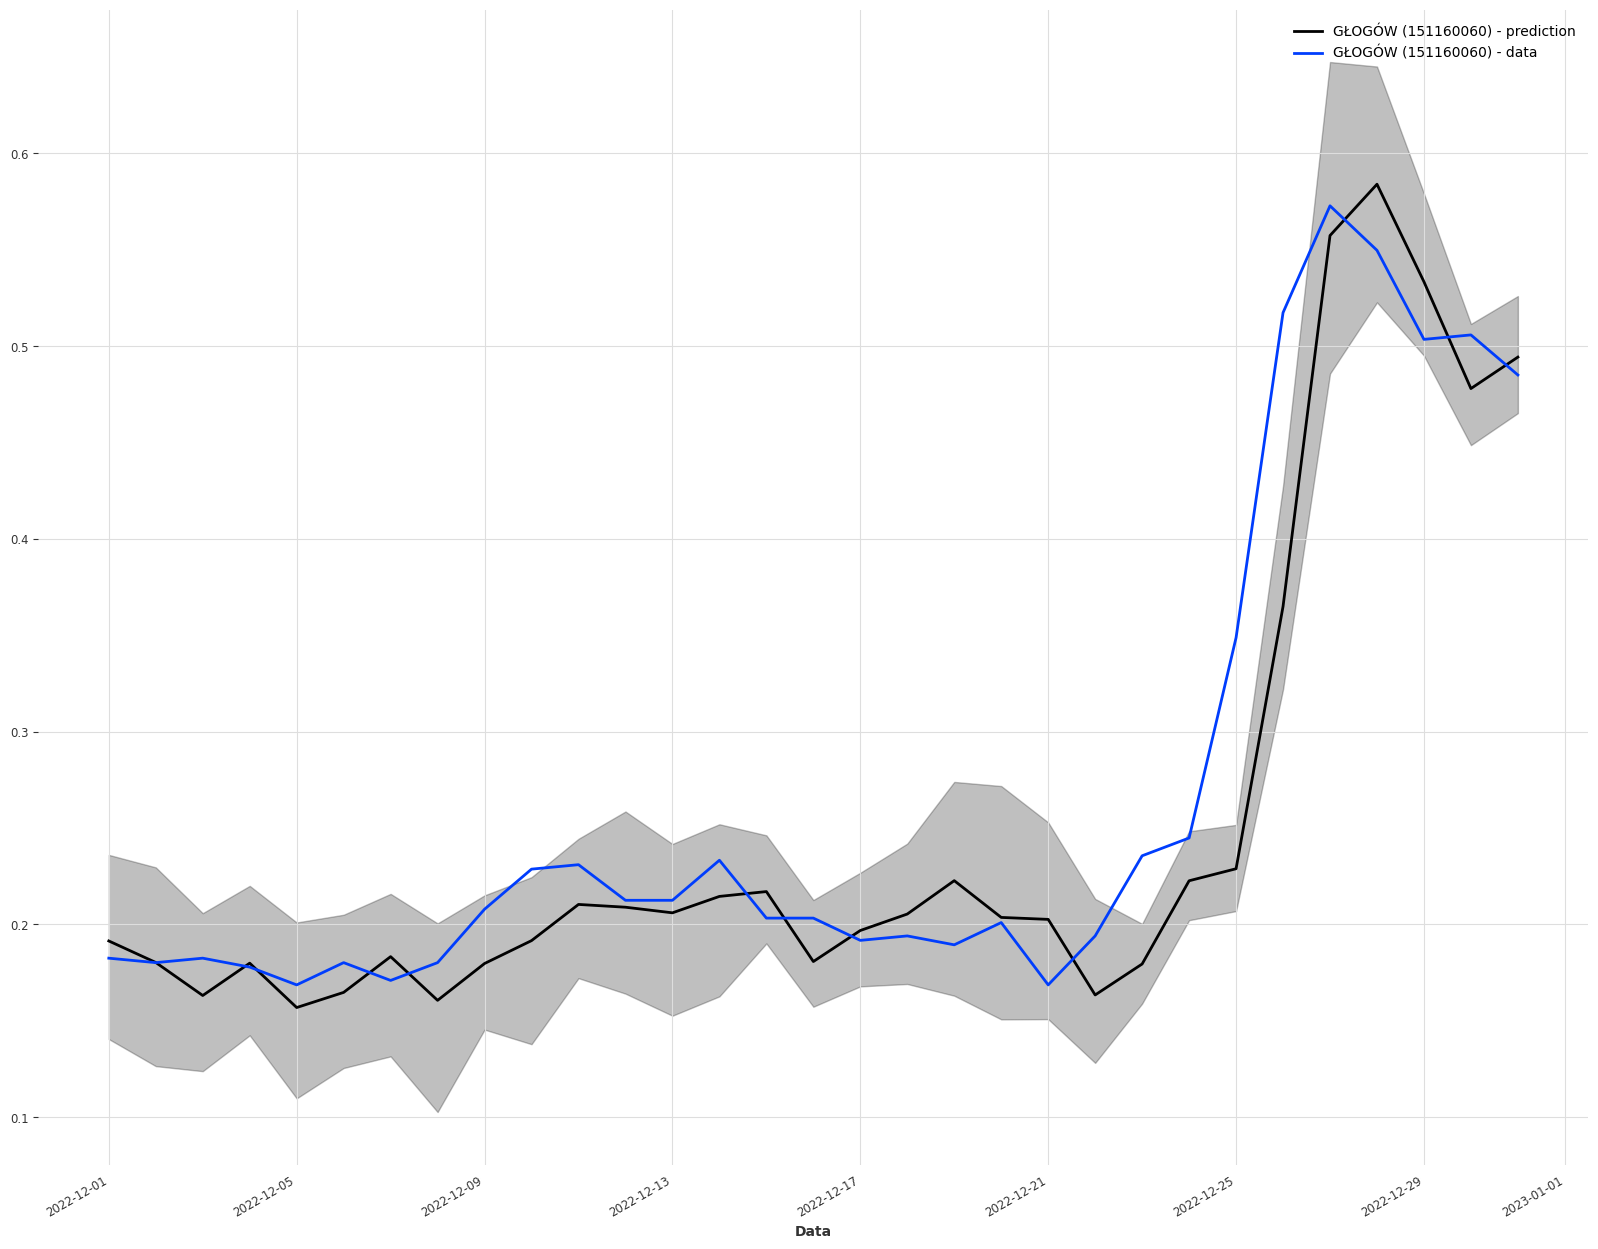

In [133]:
print("MAPE: {:.4f}%".format(mape(hydro_pred_historical_1_day[1:], hydro_val)))
print("MSE: {:.4f}%".format(mse(hydro_pred_historical_1_day[1:], hydro_val)))
print("RMSE: {:.4f}".format(rmse(hydro_pred_historical_1_day[1:], hydro_val)))

hydro_pred_historical_1_day[1:].plot(label='GŁOGÓW (151160060) - prediction')
hydro_val.plot(label='GŁOGÓW (151160060) - data')

MAPE: 91.2742%
MSE: 0.0329%
RMSE: 0.1814


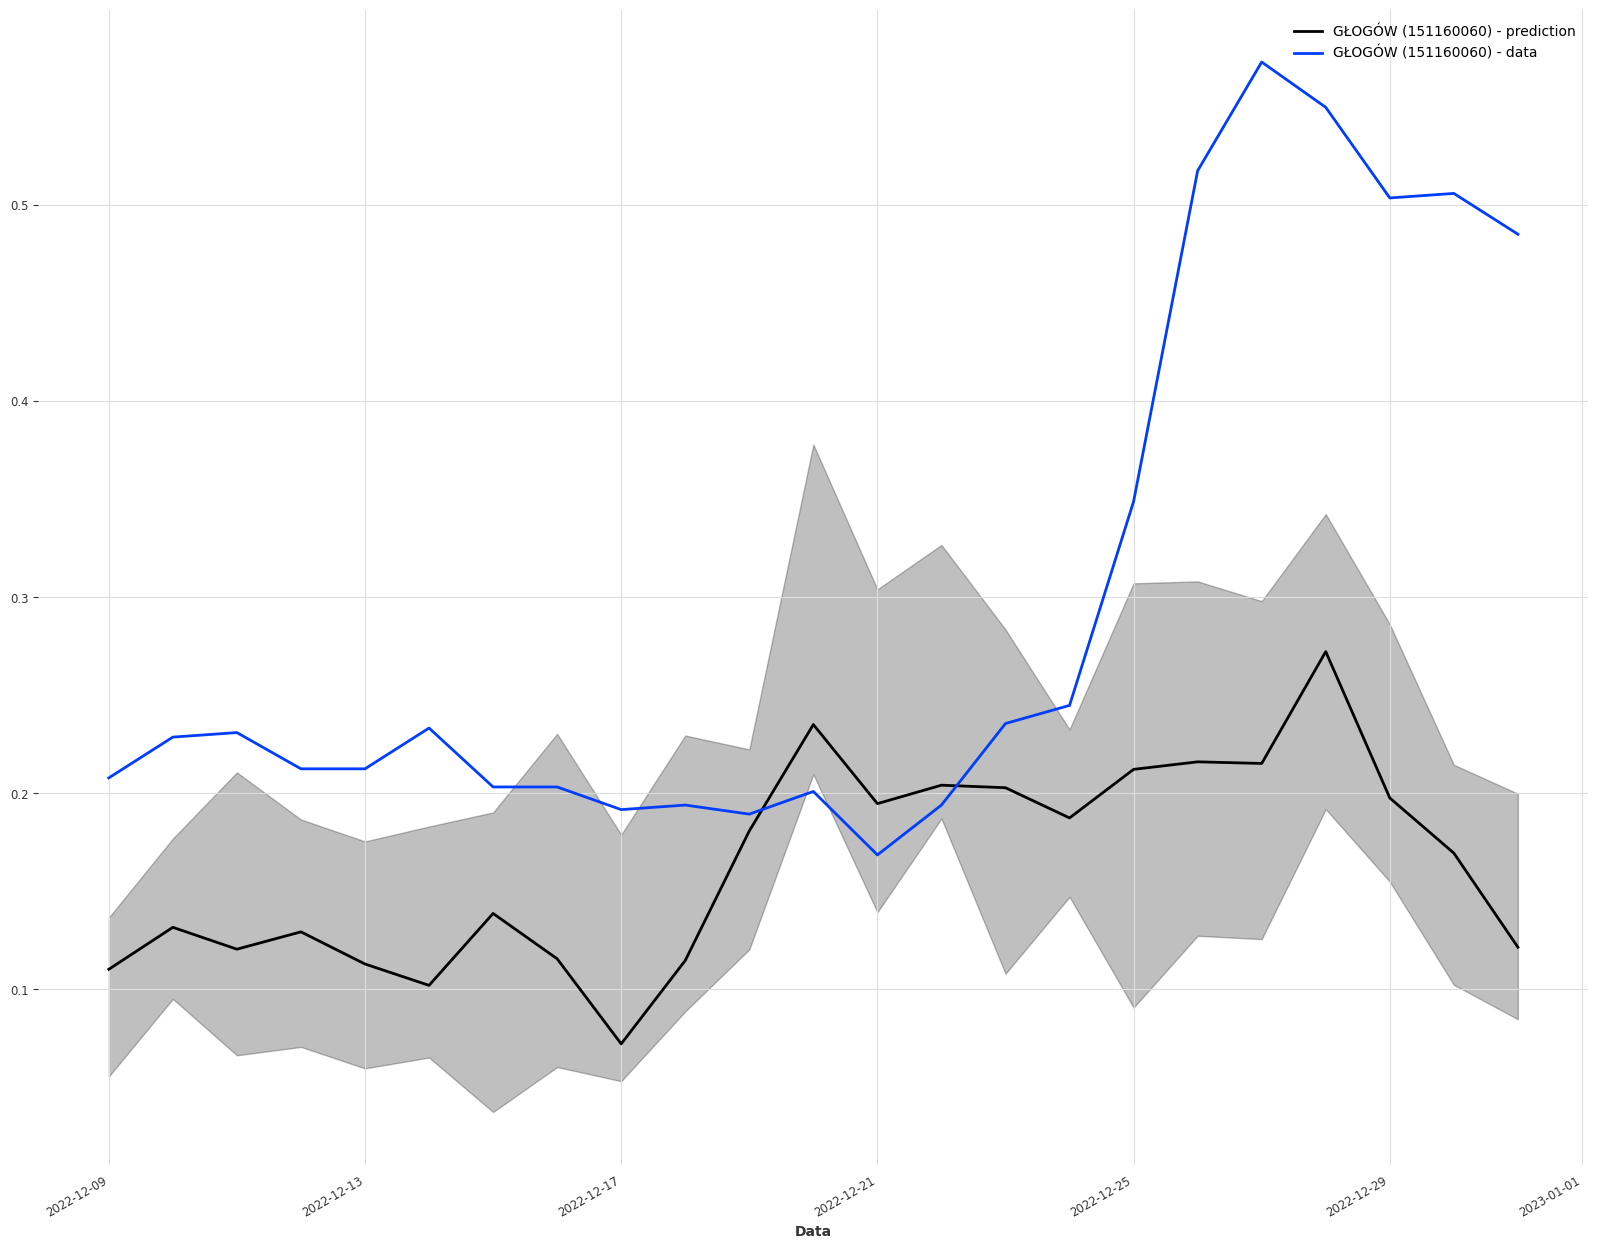

In [132]:
print("MAPE: {:.4f}%".format(mape(hydro_pred_historical_10_day, hydro_val[8:])))
print("MSE: {:.4f}%".format(mse(hydro_pred_historical_10_day, hydro_val[8:])))
print("RMSE: {:.4f}".format(rmse(hydro_pred_historical_10_day, hydro_val[8:])))

hydro_pred_historical_10_day.plot(label='GŁOGÓW (151160060) - prediction')
hydro_val[8:].plot(label='GŁOGÓW (151160060) - data')

In [121]:
hydro_pred_historical_1_day_unscalled = hydro_scaler.inverse_transform(hydro_pred_historical_1_day)
hydro_pred_historical_10_day_unscalled = hydro_scaler.inverse_transform(hydro_pred_historical_10_day)

hydro_val_unscalled = hydro_scaler.inverse_transform(hydro_val)

MAPE: 5.1588%
MSE: 306.4136%
RMSE: 17.5047


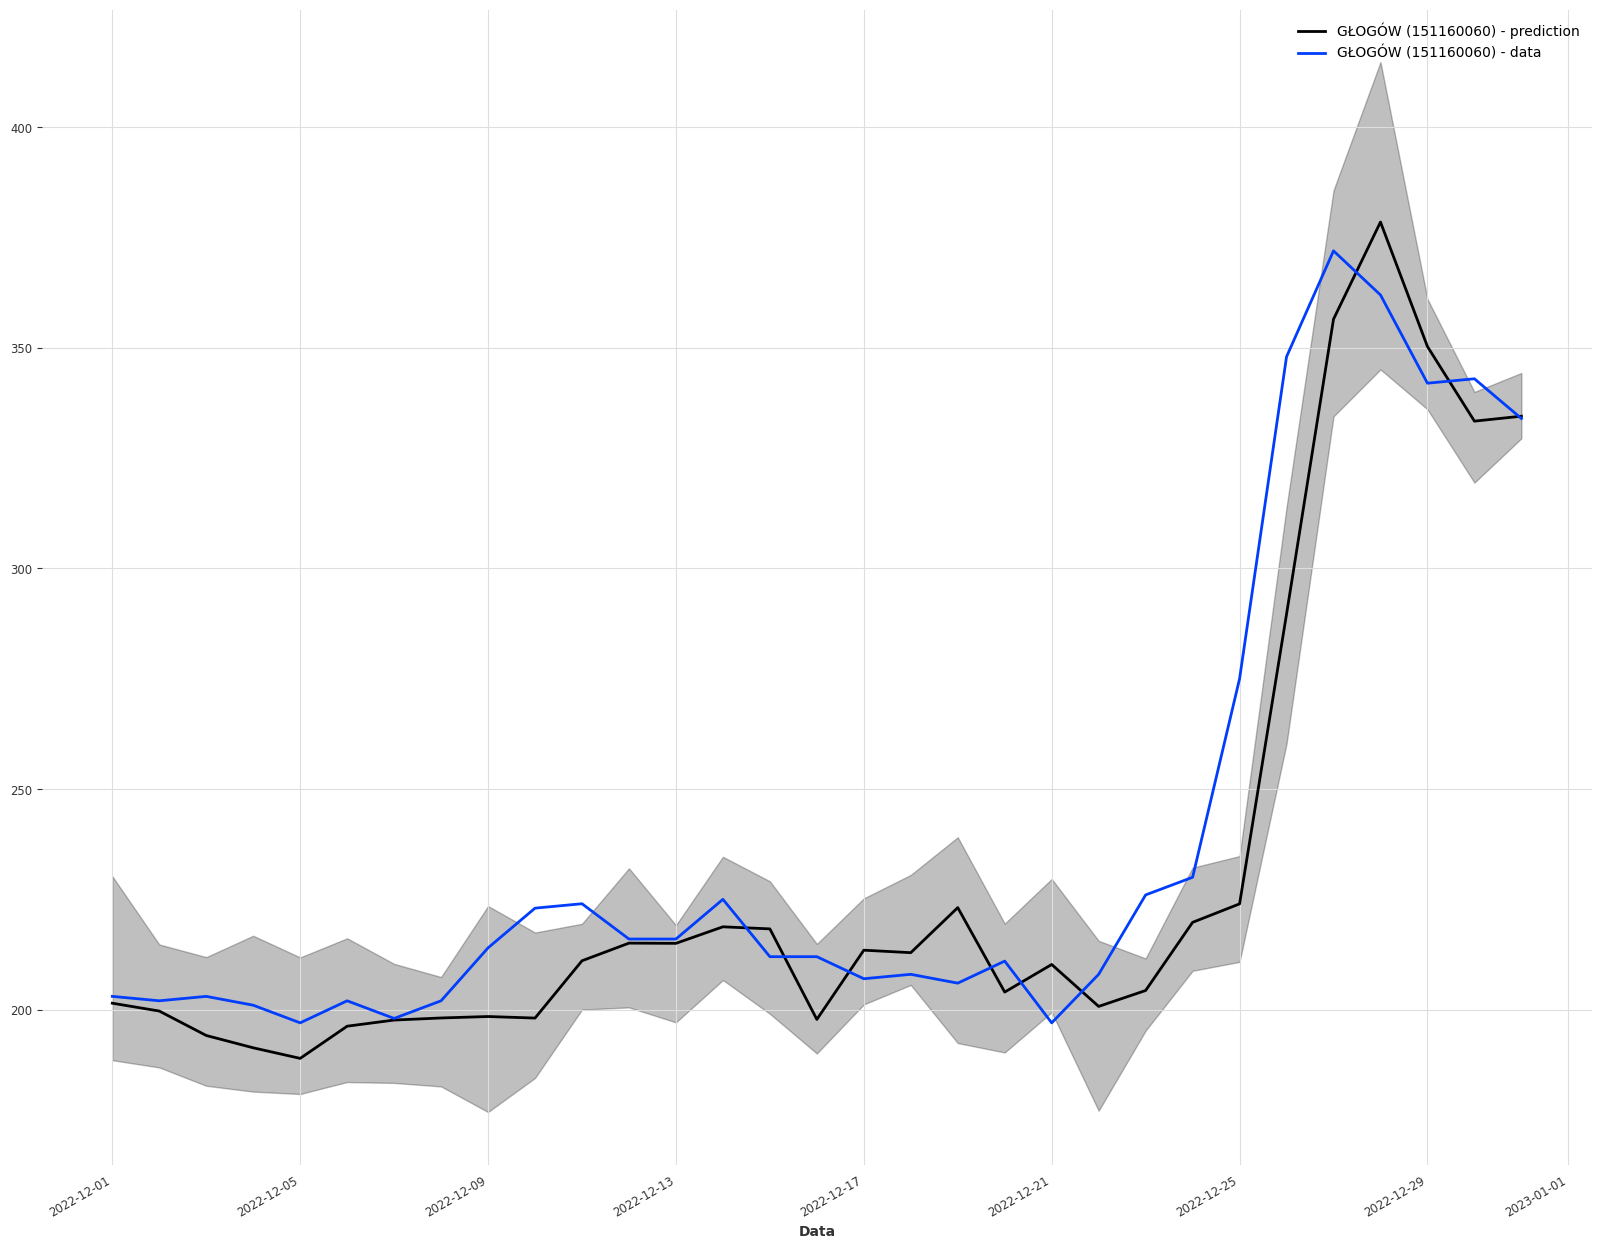

In [130]:
print("MAPE: {:.4f}%".format(mape(hydro_pred_historical_1_day_unscalled[1:], hydro_val_unscalled)))
print("MSE: {:.4f}%".format(mse(hydro_pred_historical_1_day_unscalled[1:], hydro_val_unscalled)))
print("RMSE: {:.4f}".format(rmse(hydro_pred_historical_1_day_unscalled[1:], hydro_val_unscalled)))

hydro_pred_historical_1_day_unscalled[1:].plot(label='GŁOGÓW (151160060) - prediction')
hydro_val_unscalled.plot(label='GŁOGÓW (151160060) - data')

MAPE: 30.3359%
MSE: 5932.3656%
RMSE: 77.0219


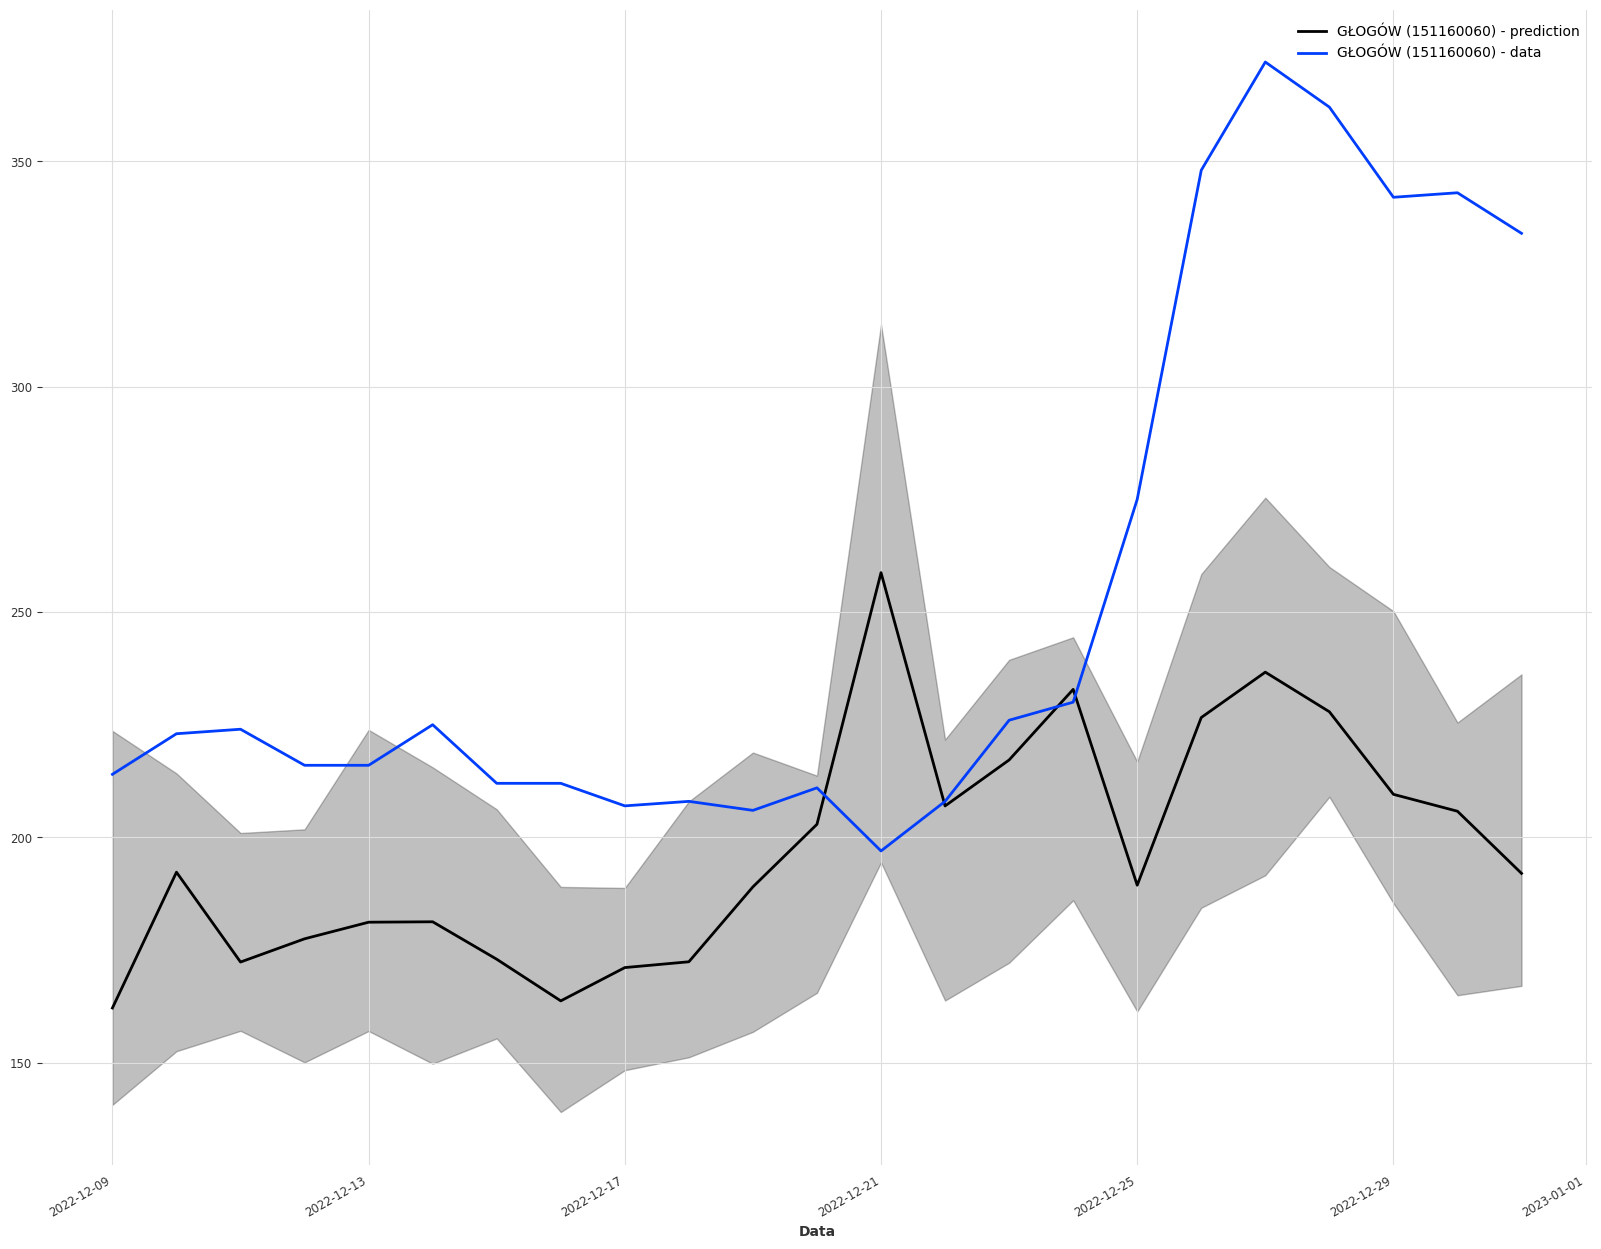

In [134]:
print("MAPE: {:.4f}%".format(mape(hydro_pred_historical_10_day_unscalled, hydro_val_unscalled[8:])))
print("MSE: {:.4f}%".format(mse(hydro_pred_historical_10_day_unscalled, hydro_val_unscalled[8:])))
print("RMSE: {:.4f}".format(rmse(hydro_pred_historical_10_day_unscalled, hydro_val_unscalled[8:])))

hydro_pred_historical_10_day_unscalled.plot(label='GŁOGÓW (151160060) - prediction')
hydro_val_unscalled[8:].plot(label='GŁOGÓW (151160060) - data')

In [ ]:
# predict normal hydro data
# predict two next months 

hydro_pred_future = deep_ar.predict(n=60, future_covariates=meteo_ts)

In [ ]:
hydro_pred_future_unscalled = hydro_scaler.inverse_transform(hydro_pred_future)

In [ ]:
hydro_pred_future_unscalled_df = hydro_pred_future_unscalled.pd_dataframe()

In [ ]:
# save to file
hydro_pred_unscalled_df.to_csv('/cuvalley_23/Zadanie3-data/pred_df.csv')